In [1]:
%cd ./n9_rrs_rl/

/home/cleversonahum/Documents/ai6g/n9_rrs_rl


# Simple scenario with 2 UEs and 2 basestations

The configuration files are stored in the `n9_rrs_rl/env_config/` folder. We can edit the config file in order to deploy the desired communication system scenario. The `n9_rrs_rl/env_config/simple.yml` file in the cell below defines a scenario with 2 basestations, where each basestation has a bandwidth of 2Hz and 2 resource blocks (RBs - Allocation unit). Therefore, each RB corresponds to 1Hz in each basestation.

In this simple scenario we consider only one slice, which can be assumed as a scenario without RAN slicing (since all the network belongs to the same slice).

We have 2 UEs in the system, where each UE has a maximum buffer latency of 10 steps (or milliseconds in case you consider each step as 1ms), so every time a packet waits more than 10ms in the buffer it should be dropped. The maximum number of packets in the buffer are 20 and 10 packets for UE 1 and 2, respectively. So every time UE 1 has a full buffer status (20 packets in the buffer), it should drop the newly arrived packets since it does not have sufficient buffer space to store it. We define the packet size for each UE as 1 bit.

The variable `basestation_ue_assoc` in the basestation config section indicates the UEs association for each basestation. It has a dimension $B$ x $U$, where $B$ is the total number of basestations and $U$ is the total number of UEs. The value 1 indicates that the UE is associated to the specified basestation and 0 otherwise. Therefore both UEs 1 and 2 are associated to basestations 1 and 2.

### Channel

Different channel implementation can be stored into `n9_rrs_rl/channels/` folder. A simple channel implementation returning constant spectral efficiency values is implemented in the `n9_rrs_rl/channels/simple.py` (code cell below) file to facilitate to understand our simple scenario and the simulator functions. The `SimpleChannel` inherits from the Channel class of sixg_radio_mgmt simulator, where the function step needs to return the spectral efficiency values for each BS-UE-RB, so the `spectral_efficiencies` variable has dimensions $B$ x $U$ x $R$, where $B$ is the total number of basestations, $U$ is the total number of UEs, and $R$ is the total number of RBs in each basestation. Therefore, `spectral_efficiencies[b,u,r]` represents the spectral efficiency (bit/Hz) in the basestation $b$, for UE $u$ in the RB $r$.

The `SimpleChannel` presented in the cell below (`n9_rrs_rl/channels/simple.py` file) always return a constant matrix with spectral efficiency values equals to 1 bit/Hz (`[ [[1, 1], [1, 1]], [[1, 1],[1, 1]] ]`). Therefore, every time a RB (1 Hz) is allocated to a UE, the UE will have a 1 bit/Hz throughput that corresponds to send one packet (since each packet has 1 bit). So each RB can transport one packet in our example.

It is important to emphasize that the `step()` function from `Channel` class receives an argument corresponding to the UEs mobility information, so the spectral efficiency calculation could use mobility information when implementing a realistic channel implementation.

In [2]:
# %load channels/simple.py
import numpy as np

from sixg_radio_mgmt import Channel


class SimpleChannel(Channel):
    def __init__(
        self,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        rng: np.random.Generator = np.random.default_rng(),
    ) -> None:
        super().__init__(
            max_number_ues, max_number_basestations, num_available_rbs, rng
        )

    def step(
        self, step_number: int, episode_number: int, mobilities: np.ndarray
    ) -> np.ndarray:
        spectral_efficiencies = [
            np.ones((self.max_number_ues, self.num_available_rbs[i]))
            for i in np.arange(self.max_number_basestations)
        ]

        return np.array(spectral_efficiencies)


### Mobility

Different mobility implementations can be stored into `n9_rrs_rl/mobilities/` folder. The Mobility files are responsible to generate the UEs movement and provide UE's localization, that could be used by the channel generation in case the Channel implementation uses it (as explained before). Note that in case you import channels from an external simulator, it already provides the spectral efficiencies for each UE in each RB, so it would not use the mobility information (since it already used it in the channel generation). Therefore, the mobility information will only be used in case you want to calculate the channel information online. Since we are considering that the `SimpleChannel` is returning constant spectral efficiency values, so there is no need to implement mobilities to the UEs, and we created a file `n9_rrs_rl/mobilities/simple.py` just to illustrate how it should work in case our scenario uses it.

Similar to the `Channel`class, the `Mobility` class `step()` function returns a matrix with dimensions $U$ x $2$ with constant values. Where each line represents the 2-D localization coordinate of each UE in the scenario.

In [3]:
# %load mobilities/simple.py
import numpy as np

from sixg_radio_mgmt import Mobility


class SimpleMobility(Mobility):
    def __init__(
        self, max_number_ues: int, rng: np.random.Generator = np.random.default_rng()
    ) -> None:
        super().__init__(max_number_ues, rng)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones((self.max_number_ues, 2))


### Traffic

The interpretation of the traffic flow in the simulator depends on the uplink or downlink assumption for the scenario. In case it assumes an uplink scenario, so the UEs generate data to be sent over the network to the basestation. In case it assumes a downlink scenario, the basestation generates the data to be sent over the network to the UEs. Let's assume an uplink scenario, so each UE generates data to be sent over the network to the basestation and its capacity to send information over the network depends on the number of RBs assigned to the UE and its spectral efficiency values.

The `Traffic` implementation into `n9_rrs_rl/traffics/` folder are responsible to define the amount of data that each UE would like to send over the network in each simulation step. It is important to emphasize that this amount of data depends on the assumption of application running in the UE, e.g. a UE running a video streaming application will have a different traffic pattern than a UE sending an email.

To facilitate our scenario interpretation, here we present a simple traffic scenario in `n9_rrs_rl/traffics/simple.py` file that return a constant number of bits per UE (traffic) as presented in the code cell below. The `step()` function needs to return a vector containing the traffic throughput requested by each UE in bits. In this `SimpleTraffic` implementation, we implemented that each UE will receive 4 bits per step to store in its buffer to be sent over the network after. Considering the scenario configuration, where each packet has a size of 1 bit, so each UE receives 4 packets per step.

In [4]:
# %load traffics/simple.py
import numpy as np

from sixg_radio_mgmt import Traffic


class SimpleTraffic(Traffic):
    def __init__(
        self, max_number_ues: int, rng: np.random.Generator = np.random.default_rng()
    ) -> None:
        super().__init__(max_number_ues, rng)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones(self.max_number_ues) * 4


### Agent

Now that our scenario is configured and all the mobility, traffic and channel functions are defined, we can start to model our agent that will be the responsible to allocate the radio resources (aka RBs) available in the basestations to the UEs. Our agent implementations are organized in the folder `n9_rrs_rl/agents/`. We implemented a simple round-robing agent that equally distributes the RBs available among the UEs in the agent `n9_rrs_rl/agents/round_robin.py` shown in the code cell below.

The `sixg_radio_mgmt` simulator provides an abstract class called `Agent` that shows all the required methods that the agent implementation should provide. In the case of our round-robin agent, we have the main function `step()` (similarly to the other classes) that is the responsible to allocate the RBs for each UE in each basestation. Let's start diving in the other auxiliary functions before diving into `step()` function.

The `obs_space_format()` function formats the observation space filtering all the information provided by the `sixg_radio_mgmt` environment in accordance to our agent needs. For example, the simulator environment in each step provide us with the following environment information:
- "pkt_incoming"
- "pkt_throughputs"
- "pkt_effective_thr"
- "buffer_occupancies"
- "buffer_latencies"
- "dropped_pkts"
- "mobility"
- "spectral_efficiencies"
- "basestation_ue_assoc"
- "basestation_slice_assoc"
- "slice_ue_assoc"
- "sched_decision"
- "slice_req"

But in the `obs_space_format()` function, we are selecting only the `basestation_ue_assoc` since it is the unique information needed for the round-robin implementation.

The `action_format()` is the responsible to format the agent `step()` function output (scheduling decision) to the format expected by the simulator. The scheduling decision is formatted as a matrix with dimensions $B$ x $U$ x $R$ with each element having value 1 to indicate that the RB was allocated to the UE in a specific basestation, or 0 otherwise. A possible scheduling decision variable for our scenario is `[ [[1, 0], [0, 1]], [[0, 1],[1, 0]] ]`, which indicates that in the first basestation the RB 1 was allocated to the UE 1, and the second RB was allocated to UE 2. In the basestation 2, the UE 1 received the RB 2 and the UE 2 received the RB 1.

Independent of the method used (RL, ML, heuristic...) the `action_format()` function needs to convert the method output to the format accepted by the simulator. In our scenario of the cell below, the `step()` function output already obbeys the matrix dimensions $B$ x $U$ x $R$, so the `action_format()` only returns the action generated by the `step()` function.

The `calculated_reward()` function is usually associated to the RL training process, so it is not needed in this moment that we are implementing a round-robin agent.

Finally, the `step()` function will receive the filtered observation space obtained from `obs_space_format()` function, and it will generate the scheduling decision to be used in the `action_format()` function to be used in the `sixg_radio_mgmt` environment. The `step()` function first creates an `allocation_rbs` variable with dimension $B$ x $U$ x $R$, and after starts to equally allocate the RBs available for each UE in the basestations that they are connected.

In [5]:
# %load agents/round_robin.py
from typing import Union

import numpy as np

from sixg_radio_mgmt import Agent, CommunicationEnv


class RoundRobin(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
    ) -> None:
        super().__init__(
            env, max_number_ues, max_number_basestations, num_available_rbs
        )

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        allocation_rbs = [
            np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
            for basestation in np.arange(self.max_number_basestations)
        ]
        for basestation in np.arange(self.max_number_basestations):
            ue_idx = 0
            rb_idx = 0
            while rb_idx < self.num_available_rbs[basestation]:
                if obs_space[basestation][ue_idx] == 1:
                    allocation_rbs[basestation][ue_idx][rb_idx] += 1
                    rb_idx += 1
                ue_idx += 1 if ue_idx + 1 != self.max_number_ues else -ue_idx

        return np.array(allocation_rbs)

    def obs_space_format(self, obs_space: dict) -> np.ndarray:
        return np.array(obs_space["basestation_ue_assoc"])

    def calculate_reward(self, obs_space: dict) -> float:
        return 0

    def action_format(self, action: np.ndarray) -> np.ndarray:
        return action


### Executing the round-robin agent in the configured environment


First, let's import the round-robin agent, simple channel, mobility traffic and the communication environment created.

In [6]:
import numpy as np
from tqdm import tqdm

from agents.round_robin import RoundRobin
from channels.simple import SimpleChannel
from mobilities.simple import SimpleMobility
from sixg_radio_mgmt import CommunicationEnv
from traffics.simple import SimpleTraffic

Now, we create the communication environment using the `CommunicationEnv` from `sixg_radio_mgmt`. The string `"simple"` used as argument in the `CommunicationEnv` creation tells the environment to create the scenario described in `n9_rrs_rl/env_config/simple.yml` already described in this tutorial. We also pass the `SimpleChannel`, `SimpleTraffic` and `SimpleMobility` to be used by the communication environment.

In [7]:
seed = 10
rng = np.random.default_rng(seed) if seed != -1 else np.random.default_rng()
comm_env = CommunicationEnv(
    SimpleChannel,
    SimpleTraffic,
    SimpleMobility,
    "simple",
    rng=rng,
)

In the code cell below we instantiate the round-robin agent passing the communication environment, the number of UE

In [8]:
round_robin = RoundRobin(
                comm_env,  # Communication environment
                2, # Max number of UEs
                2, # Max number of basestations
                np.array([2, 2])) # Number of RBs available in each basestation
# Here we set the agent functions used in the communication environment                
comm_env.set_agent_functions(
    round_robin.obs_space_format,
    round_robin.action_format,
    round_robin.calculate_reward,
)

Finally, in the code cell below we create the interaction between the round-robin agent and environment. The `round_robin.step(obs)` receives the `obs` variable from the communication environment filtered with `obs_space_format()` function provided by the agent. The `round_robin.step(obs)` generated the `sched_decision` that it is after applied in the `comm_env.step(sched_decision)` distributing the RBs among the UEs.

In [9]:
obs = comm_env.reset()
number_steps = 10
for step_number in tqdm(np.arange(comm_env.max_number_steps)):
    sched_decision = round_robin.step(obs)
    obs, _, end_ep, _ = comm_env.step(sched_decision)
    if end_ep:
        comm_env.reset()

100%|██████████| 10/10 [00:00<00:00, 435.89it/s]


When the process finishes, it generates a log file containing all the network information data generated in each step of the simulation in the folder `n9_rrs_rl/hist/` with the name of the simulation. Let's take a look in the information generated.

In [10]:
hist = comm_env.metrics_hist.read("./", "test", 1) # (root_path, simulation_name, episode_number)
print("Collected information: ", list(hist.keys()))
print("Scheduling decisions: \n",hist["sched_decision"][0:2])
# The round-robin always schedules 1 RB for each UE in each basestation

Collected information:  ['pkt_incoming', 'pkt_throughputs', 'pkt_effective_thr', 'buffer_occupancies', 'buffer_latencies', 'dropped_pkts', 'mobility', 'spectral_efficiencies', 'basestation_ue_assoc', 'basestation_slice_assoc', 'slice_ue_assoc', 'sched_decision', 'reward', 'slice_req']
Scheduling decisions: 
 [[[[1. 0.]
   [0. 1.]]

  [[1. 0.]
   [0. 1.]]]


 [[[1. 0.]
   [0. 1.]]

  [[1. 0.]
   [0. 1.]]]]


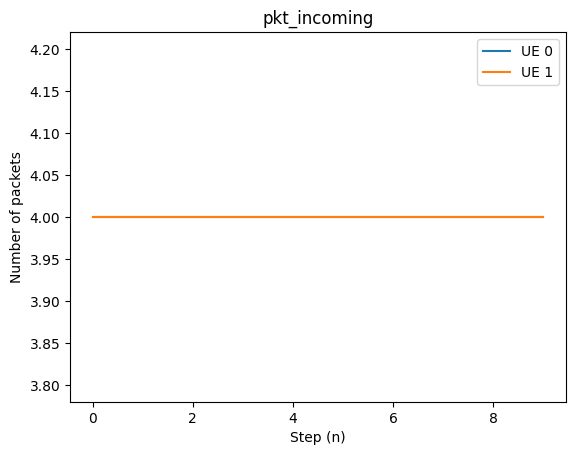

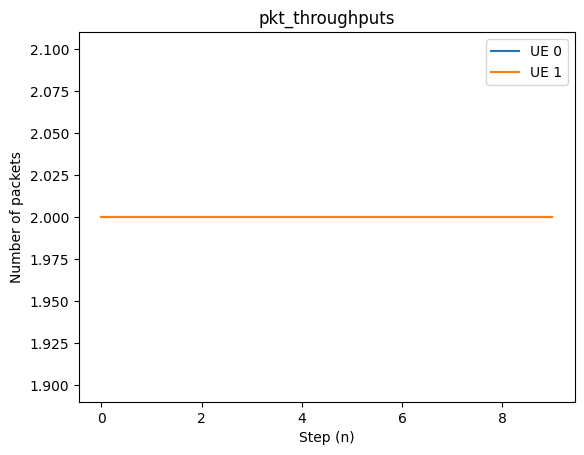

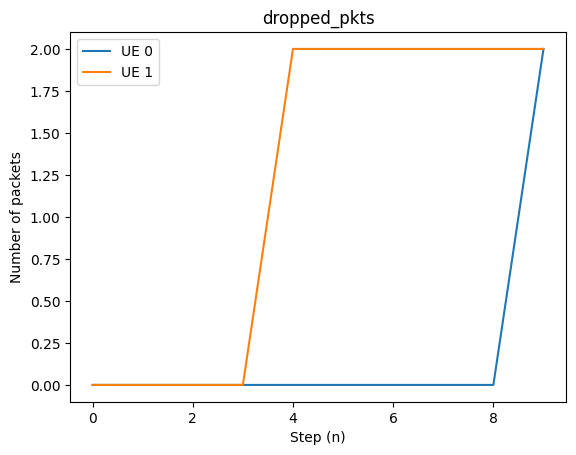

In [11]:
import matplotlib.pyplot as plt
metrics = ['pkt_incoming', 'pkt_throughputs', 'dropped_pkts']

for metric in metrics:
	plt.figure()
	for ue in np.arange(comm_env.max_number_ues):
		plt.plot(hist[metric][:,ue], label="UE {}".format(ue))
		plt.title(metric)
		plt.legend()
		plt.xlabel("Step (n)")
		plt.ylabel("Number of packets")
	plt.show()

From the obtained results, we perceive that each UE is always having a packet throughput of 2 packets/step, and they are always receiving 4 packets/step hence it will cause an increase in the buffer of both UEs since they never reach a sufficient throughput to decrease the buffer, until the buffer is fulfilled and packets start to get dropped. The UE 1 starts to drop its packets sooner than UE 2 due to its smaller buffer capacity (10 packets) in comparison to UE 2 buffer capacity (20 packets).

### Implementing a simple RL agent to the same scenario

Using the same `Agent` class from `sixg_radio_mgmt` scenario, we created a simple RL agent in the file `n9_rrs_rl/agents/rl_simple.py` based on a Soft-actor critic (SAC) implementation from Stable-baselines3 library (agent's code in the cell below).

In [12]:
# %load agents/rl_simple.py
from typing import Union

import numpy as np
from gym import spaces
from stable_baselines3.sac.sac import SAC

from sixg_radio_mgmt import Agent, CommunicationEnv


class RLSimple(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env, max_number_ues, max_number_basestations, num_available_rbs, seed
        )
        self.agent = SAC(
            "MlpPolicy",
            env,
            verbose=0,
            tensorboard_log="./tensorboard-logs/",
            seed=self.seed,
        )

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        return self.agent.predict(np.asarray(obs_space), deterministic=True)[0]

    def train(self, total_timesteps: int) -> None:
        self.agent.learn(total_timesteps=int(total_timesteps), callback=[])

    def save(self, filename: str) -> None:
        self.agent.save(filename)

    def load(self, filename: str, env: CommunicationEnv) -> None:
        self.agent = SAC.load(filename, env=env)

    @staticmethod
    def obs_space_format(obs_space: dict) -> np.ndarray:
        formatted_obs_space = np.array([])
        hist_labels = [
            # "pkt_incoming",
            "dropped_pkts",
            # "pkt_effective_thr",
            "buffer_occupancies",
            # "spectral_efficiencies",
        ]
        for hist_label in hist_labels:
            if hist_label == "spectral_efficiencies":
                formatted_obs_space = np.append(
                    formatted_obs_space,
                    np.squeeze(np.sum(obs_space[hist_label], axis=2)),
                    axis=0,
                )
            else:
                formatted_obs_space = np.append(
                    formatted_obs_space, obs_space[hist_label], axis=0
                )

        return formatted_obs_space

    @staticmethod
    def calculate_reward(obs_space: dict) -> float:
        reward = -np.sum(obs_space["dropped_pkts"])
        return reward

    @staticmethod
    def get_action_space() -> spaces.Box:
        return spaces.Box(low=-1, high=1, shape=(2 * 2 * 2,))

    @staticmethod
    def get_obs_space() -> spaces.Box:
        return spaces.Box(low=0, high=np.inf, shape=(2 * 2,), dtype=np.float64)

    @staticmethod
    def action_format(
        action: np.ndarray,
    ) -> np.ndarray:
        action = np.reshape(action, (2, 2, 2))
        sched_decision = np.copy(action)
        sched_decision[0, 0] = (action[0, 0] >= action[0, 1]).astype(int)
        sched_decision[0, 1] = (action[0, 0] < action[0, 1]).astype(int)
        sched_decision[1, 0] = (action[1, 0] >= action[1, 1]).astype(int)
        sched_decision[1, 1] = (action[1, 0] < action[1, 1]).astype(int)

        return sched_decision


In [13]:
import numpy as np
from tqdm import tqdm

from agents.rl_simple import RLSimple

seed = 10
rng = np.random.default_rng(seed) if seed != -1 else np.random.default_rng()
comm_env = CommunicationEnv(
    SimpleChannel,
    SimpleTraffic,
    SimpleMobility,
    "simple",
    rng=rng,
    obs_space=RLSimple.get_obs_space,
    action_space=RLSimple.get_action_space,
)
rl_agent = RLSimple(comm_env, 2, 2, np.array([2, 2]), seed=seed)
comm_env.set_agent_functions(
    rl_agent.obs_space_format, rl_agent.action_format, rl_agent.calculate_reward
)
total_number_steps = 10000
rl_agent.train(total_number_steps)

total_number_steps_test = 10
obs = comm_env.reset()
for step_number in tqdm(np.arange(total_number_steps_test)):
    sched_decision = rl_agent.step(obs)
    obs, _, end_ep, _ = comm_env.step(sched_decision)
    if end_ep:
        comm_env.reset()


2022-09-01 15:11:02.429516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 15:11:02.429580: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|██████████| 10000/10000 [00:39<00:00, 255.67it/s]


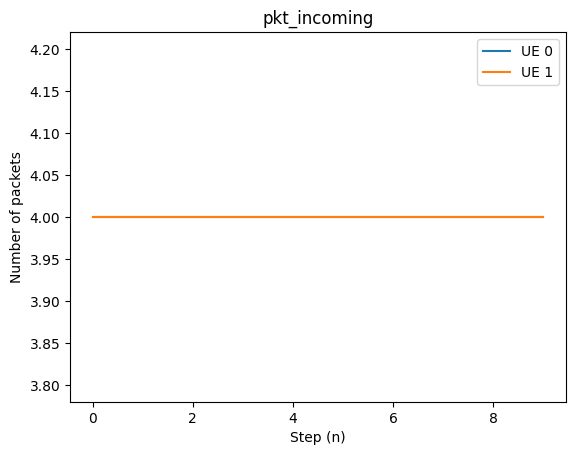

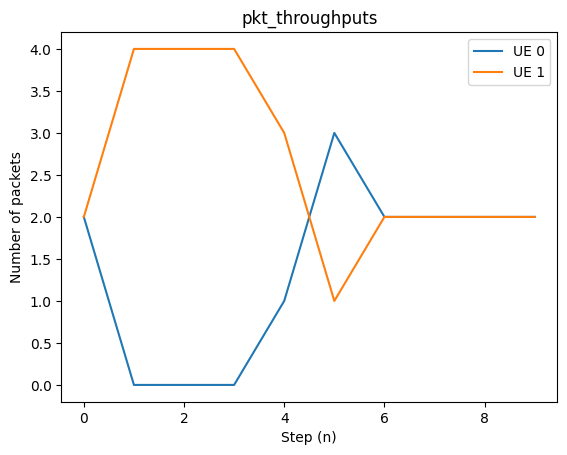

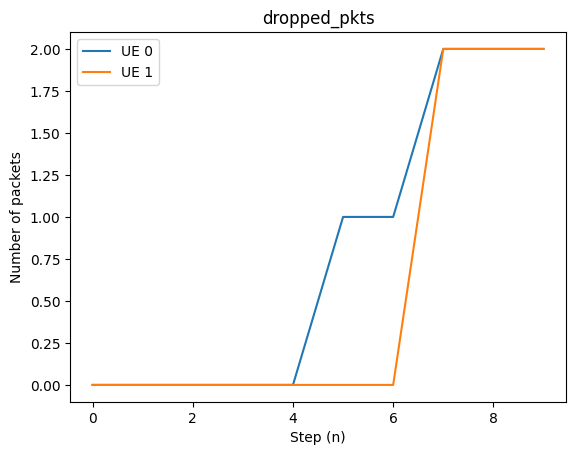

In [14]:
import matplotlib.pyplot as plt

hist = comm_env.metrics_hist.read("./", "test", 1) # (root_path, simulation_name, episode_number)
metrics = ['pkt_incoming', 'pkt_throughputs', 'dropped_pkts']

for metric in metrics:
	plt.figure()
	for ue in np.arange(comm_env.max_number_ues):
		plt.plot(hist[metric][:,ue], label="UE {}".format(ue))
		plt.title(metric)
		plt.legend()
		plt.xlabel("Step (n)")
		plt.ylabel("Number of packets")
	plt.show()